In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
random_state=0

In [2]:
df= pd.read_csv('studentmath.csv')

In [3]:
def assign_cat_codes(df, col_name):
    col_index = df.columns.get_loc(col_name)
    df[col_name] = df[col_name].astype('category')
    df.insert(col_index + 1, f'{col_name}_cat', df[col_name].cat.codes)
    df.drop(columns=[col_name], inplace=True)

columns_to_convert = ['school', 'sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']

for col in columns_to_convert:
    assign_cat_codes(df, col)

In [4]:
df.head()

,school_cat,sex_cat,age,address_cat,famsize_cat,Pstatus_cat,Medu,Fedu,Mjob_cat,Fjob_cat,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


In [5]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1] 


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)

In [7]:
def preprocess_data(X_train, X_test, y_train, kappa):
    # Find columns with extra values
    unique_values = {col: X_train[col].unique() for col in X_train.columns}
    columns_with_extra_values = []

    for col in X_train.columns:
        extra_values = set(X_test[col].unique()) - set(unique_values[col])
        if extra_values:
            print(f"Warning: There are values in column '{col}' of X_test that are not present in X_train.")
            columns_with_extra_values.append(col)

    # Calculate mean for unique values in all columns
    mean_values = {}
    
    for col in X_train.columns:
        unique_values = X_train[col].unique()
        col_mean_values = {}
        
        for value in unique_values:
            indices = X_train[X_train[col] == value].index
            col_mean_values[value] = y_train.iloc[indices].mean()
        
        mean_values[col] = col_mean_values

    # Replace unique values in X_train and X_test with their corresponding means only for columns without extra values
    for col, col_mean_values in mean_values.items():
        if col not in columns_with_extra_values:
            X_train[col] = X_train[col].apply(lambda x: col_mean_values[x])
            X_test[col] = X_test[col].apply(lambda x: col_mean_values[x])

    # Apply proposed algorithm to columns with extra values for all values
    for col in columns_with_extra_values:
        # Xtrain
        d_train = np.zeros((len(X_train), len(X_train)))
        for i in range(len(X_train)):
            for j in range(len(X_train)):
                d_train[i, j] = np.linalg.norm(X_train.iloc[i] - X_train.iloc[j])

        c_train = np.zeros(len(X_train))
        for i in range(len(X_train)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_train[i, j]) ** kappa)
                v += 1 / ((1 + d_train[i, j]) ** kappa)
            c_train[i] = l / v

        X_train[col] = c_train

        #Xtest
        d_test = np.zeros((len(X_test), len(X_train)))
        for i in range(len(X_test)):
            for j in range(len(X_train)):
                d_test[i, j] = np.linalg.norm(X_test.iloc[i] - X_train.iloc[j])

        c_test = np.zeros(len(X_test))
        for i in range(len(X_test)):
            l = 0
            v = 0
            for j in range(len(y_train)):
                l += y_train.iloc[j] / ((1 + d_test[i, j]) ** kappa)
                v += 1 / ((1 + d_test[i, j]) ** kappa)
            c_test[i] = l / v

        X_test[col] = c_test

    return X_train, X_test


In [8]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

kappa = 5
X_train_preprocessed, X_test_preprocessed = preprocess_data(X_train, X_test, y_train, kappa)

<ipython-input-7-b7bf4d0b1ffa>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].apply(lambda x: col_mean_values[x])
<ipython-input-7-b7bf4d0b1ffa>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].apply(lambda x: col_mean_values[x])
<ipython-input-7-b7bf4d0b1ffa>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [9]:
X_train = X_train_preprocessed
X_train
X_test = X_test_preprocessed

In [10]:
def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)

kappa = 1.000, avg MSE = 16.950
kappa = 2.000, avg MSE = 13.311
kappa = 3.000, avg MSE = 10.422
kappa = 4.000, avg MSE = 8.237
kappa = 5.000, avg MSE = 6.657
kappa = 6.000, avg MSE = 5.570
kappa = 7.000, avg MSE = 4.842
kappa = 8.000, avg MSE = 4.360
kappa = 9.000, avg MSE = 4.044
kappa = 10.000, avg MSE = 3.843
kappa = 11.000, avg MSE = 3.723
kappa = 12.000, avg MSE = 3.660
kappa = 13.000, avg MSE = 3.637
kappa = 14.000, avg MSE = 3.642
kappa = 15.000, avg MSE = 3.665
kappa = 16.000, avg MSE = 3.700


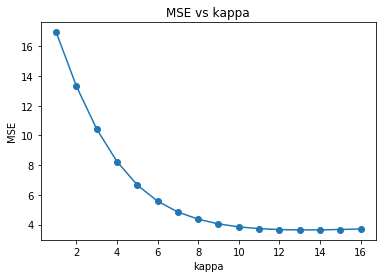

In [11]:
kf = KFold(n_splits=10)
kappa_values = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
mse_values = []

for kappa in kappa_values:
    mse = 0.0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        y_pred = prop_reg(X_test, X_train, y_train, y_test, kappa)
        mse += mean_squared_error(y_test, y_pred)
    mse /= kf.get_n_splits(X)
    mse_values.append(mse)
    print(f"kappa = {kappa:.3f}, avg MSE = {mse:.3f}")

# plot the MSE vs kappa curve
plt.plot(kappa_values, mse_values, '-o')
plt.xlabel('kappa')
plt.ylabel('MSE')
plt.title('MSE vs kappa')
plt.show()

In [12]:
# find the index of the minimum MSE value
min_index = np.argmin(mse_values)

# print the minimum MSE value and the corresponding kappa value
print(f"Minimum MSE: {mse_values[min_index]:.3f}, Kappa value: {kappa_values[min_index]}")


Minimum MSE: 3.637, Kappa value: 13
